In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 3.0 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import geopandas as gpd

In [ ]:
# partidos = '/content/drive/MyDrive/Colab Notebooks/Estudos_Ciencia_Politica/TSE/votacao_partido_munzona_2022_BRASIL_dep_federal.csv'
# df_partidos = pd.read_csv(partidos, sep=';', encoding='latin-1')

In [ ]:
candidatos = '/content/drive/MyDrive/Colab Notebooks/Estudos_Ciencia_Politica/TSE/votacao_candidato_munzona_2022_BRASIL_dep_federal.csv'
df_candidatos = pd.read_csv(candidatos, sep=';', encoding='latin-1')

In [ ]:
candidatos_e_municipios = df_candidatos[['SQ_CANDIDATO', 'CD_MUNICIPIO', 'SG_UF', 'QT_VOTOS_NOMINAIS_VALIDOS']]
votacao_total = candidatos_e_municipios.QT_VOTOS_NOMINAIS_VALIDOS.sum()
votacao_candidatos_por_municipio = pd.DataFrame(candidatos_e_municipios.groupby(by=['SQ_CANDIDATO', 'CD_MUNICIPIO', 'SG_UF'], as_index=False).sum())

In [ ]:
votacao_total_agrupada = votacao_candidatos_por_municipio.QT_VOTOS_NOMINAIS_VALIDOS.sum()
votacao_total == votacao_total_agrupada

True

In [ ]:
colunas_interessantes = ['SQ_CANDIDATO', 'NR_CANDIDATO', 'NM_URNA_CANDIDATO', 'DS_SITUACAO_CANDIDATURA', 'NR_PARTIDO', 'SG_PARTIDO', 'SG_FEDERACAO', 'CD_SIT_TOT_TURNO', 'DS_SIT_TOT_TURNO']

In [ ]:
df_infos_candidatos = df_candidatos[colunas_interessantes].drop_duplicates()

In [ ]:
votacao_total_cada_um = pd.DataFrame(votacao_candidatos_por_municipio.groupby(by='SQ_CANDIDATO', as_index=False).sum())
votacao_total_cada_um.drop(columns='CD_MUNICIPIO', inplace=True)
votacao_total_cada_um.rename(columns={'QT_VOTOS_NOMINAIS_VALIDOS': 'QT_VOTOS_NOMINAIS_VALIDOS_CAND'}, inplace=True)
votacao_total_cada_um.QT_VOTOS_NOMINAIS_VALIDOS_CAND.sum() == votacao_total_agrupada

True

In [ ]:
votacao_total_cada_mun = pd.DataFrame(votacao_candidatos_por_municipio.groupby(by=['CD_MUNICIPIO', 'SG_UF'], as_index=False).sum())
votacao_total_cada_mun.drop(columns='SQ_CANDIDATO', inplace=True)
votacao_total_cada_mun.rename(columns={'QT_VOTOS_NOMINAIS_VALIDOS': 'QT_VOTOS_NOMINAIS_VALIDOS_MUN'}, inplace=True)
votacao_total_cada_mun.QT_VOTOS_NOMINAIS_VALIDOS_MUN.sum() == votacao_total_agrupada

True

In [ ]:
votacao_total_cada_UF = pd.DataFrame(votacao_candidatos_por_municipio.groupby(by='SG_UF', as_index=False).sum())
votacao_total_cada_UF.drop(columns=['SQ_CANDIDATO', 'CD_MUNICIPIO'], inplace=True)
votacao_total_cada_UF.rename(columns={'QT_VOTOS_NOMINAIS_VALIDOS': 'QT_VOTOS_NOMINAIS_VALIDOS_UF'}, inplace=True)
votacao_total_cada_UF.QT_VOTOS_NOMINAIS_VALIDOS_UF.sum() == votacao_total_agrupada

True

In [ ]:
principal = pd.merge(votacao_candidatos_por_municipio, votacao_total_cada_um, on='SQ_CANDIDATO', how='left')
principal = pd.merge(principal, votacao_total_cada_mun, on=['CD_MUNICIPIO', 'SG_UF'], how='left')
principal = pd.merge(principal, votacao_total_cada_UF, on='SG_UF', how='left')
principal['g'] = (((principal.QT_VOTOS_NOMINAIS_VALIDOS / principal.QT_VOTOS_NOMINAIS_VALIDOS_CAND) - (principal.QT_VOTOS_NOMINAIS_VALIDOS_MUN / principal.QT_VOTOS_NOMINAIS_VALIDOS_UF))**2)
principal['QL'] = (((principal.QT_VOTOS_NOMINAIS_VALIDOS / principal.QT_VOTOS_NOMINAIS_VALIDOS_CAND) / (principal.QT_VOTOS_NOMINAIS_VALIDOS_MUN / principal.QT_VOTOS_NOMINAIS_VALIDOS_UF)))

correspondencia_codigos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Estudos_Ciencia_Politica/TSE/correspondencia_codigos_municipio_tse_ibge.csv')
c = correspondencia_codigos[['codigo_tse', 'codigo_ibge']]

principal = pd.merge(principal, c, how='left', left_on='CD_MUNICIPIO', right_on='codigo_tse')
principal.drop(columns='codigo_tse', inplace=True)

In [ ]:
G = pd.DataFrame(principal.groupby(by='SQ_CANDIDATO', as_index=False).sum())
G.drop(columns=['CD_MUNICIPIO', 'codigo_ibge', 'QT_VOTOS_NOMINAIS_VALIDOS', 'QT_VOTOS_NOMINAIS_VALIDOS_CAND', 'QT_VOTOS_NOMINAIS_VALIDOS_MUN', 'QT_VOTOS_NOMINAIS_VALIDOS_UF', 'QL'], inplace=True)
G.rename(columns={'g': 'G'}, inplace=True)

In [ ]:
final = pd.merge(G, df_infos_candidatos, on='SQ_CANDIDATO', how='left')
final = pd.merge(final, votacao_total_cada_um, on='SQ_CANDIDATO', how='left')
UF_do_candidato = principal[['SQ_CANDIDATO', 'SG_UF']].drop_duplicates()
final = pd.merge(final, UF_do_candidato, on='SQ_CANDIDATO', how='left')
ordem_colunas = ['SQ_CANDIDATO', 'NR_CANDIDATO', 'NM_URNA_CANDIDATO', 'DS_SITUACAO_CANDIDATURA', 'NR_PARTIDO', 'SG_PARTIDO', 'SG_FEDERACAO', 'SG_UF', 'CD_SIT_TOT_TURNO', 'DS_SIT_TOT_TURNO', 'QT_VOTOS_NOMINAIS_VALIDOS_CAND', 'G']
final = final[ordem_colunas]

In [ ]:
G_por_situacao = pd.DataFrame(final.groupby(by=['CD_SIT_TOT_TURNO', 'DS_SIT_TOT_TURNO'], as_index=False).mean())
G_por_situacao.drop(columns=['SQ_CANDIDATO', 'NR_CANDIDATO', 'NR_PARTIDO', 'QT_VOTOS_NOMINAIS_VALIDOS_CAND'], inplace=True)
G_por_situacao

,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,G
0,2,ELEITO POR QP,0.065182
1,3,ELEITO POR MÉDIA,0.080646
2,4,NÃO ELEITO,0.220161
3,5,SUPLENTE,0.239433


In [ ]:
menor_que_meio = final.query('G<0.05').query('CD_SIT_TOT_TURNO<4').sort_values(by='G').shape[0]
entre_meio_e_um = final.query('G>0.05').query('G<0.1').query('CD_SIT_TOT_TURNO<4').sort_values(by='G').shape[0]
entre_um_e_um_e_meio = final.query('G>0.1').query('G<0.15').query('CD_SIT_TOT_TURNO<4').sort_values(by='G').shape[0]
entre_um_e_meio_e_dois = final.query('G>0.1').query('G<0.15').query('CD_SIT_TOT_TURNO<4').sort_values(by='G').shape[0]
maior_que_2 = final.query('G>0.2').query('CD_SIT_TOT_TURNO<4').sort_values(by='G').shape[0]

In [ ]:
print(f"Menor que 0.05: {menor_que_meio}\nEntre 0.05 e 0.1: {entre_meio_e_um}\nEntre 0.1 e 0.15: {entre_um_e_um_e_meio}\nEntre 0.15 e 0.2: {entre_um_e_meio_e_dois}\nMaior que 0.2: {maior_que_2}")

Menor que 0.05: 307
Entre 0.05 e 0.1: 112
Entre 0.1 e 0.15: 42
Entre 0.15 e 0.2: 42
Maior que 0.2: 39


In [ ]:
brasil = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Estudos_Ciencia_Politica/TSE/Mapa_Brasil/BR_Municipios_2021.shp')
brasil.CD_MUN = brasil.CD_MUN.astype('int64')
brasil.to_file('./drive/MyDrive/Colab Notebooks/Estudos_Ciencia_Politica/TSE/arquivos/brasil.shp')

In [ ]:
def gera_mapa_uf(uf):
  estado = uf.upper()
  ufs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Estudos_Ciencia_Politica/TSE/UFs.csv', sep=';', index_col='UF')
  codigo = int(ufs.loc[estado])*100000
  mapa = brasil.query(f'CD_MUN>{codigo}').query(f'CD_MUN<{codigo+100000}')
  return mapa[['CD_MUN', 'geometry']]

In [ ]:
def gera_grafico_QL_de(candidato, uf):
  sequencial = final.query(f'NM_URNA_CANDIDATO=="{candidato}"').SQ_CANDIDATO.values[0]
  dados = principal.query(f'SQ_CANDIDATO=={sequencial}')
  dados = pd.merge(dados, uf, how='right', left_on='codigo_ibge', right_on='CD_MUN')
  dados = gpd.GeoDataFrame(dados)
  dados.plot(column='QL', cmap='OrRd', figsize=(20,12), legend=True)

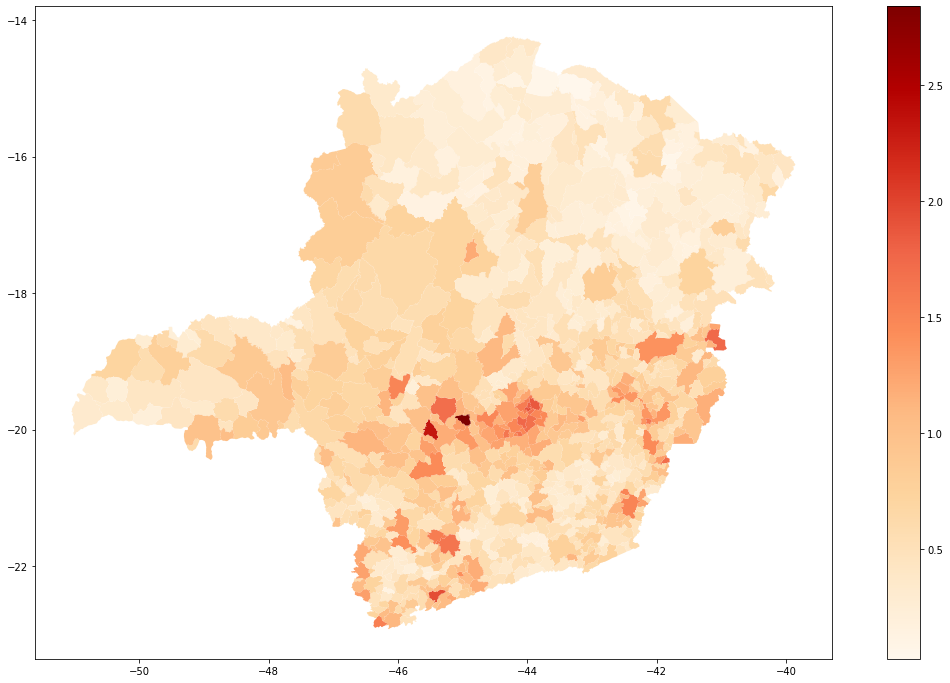

In [ ]:
mg = gera_mapa_uf("MG")
gera_grafico_QL_de("NIKOLAS FERREIRA", mg)